<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Joaquín Cisternas
- Nombre de alumno 2: Diego González


### **Link de repositorio de GitHub:** `https://github.com/jcist/MDS7202`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [185]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?.

In [186]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [187]:
# Análisis de datos
print('Hay ', df.isna().sum().sum(), ' datos faltantes')
print('Hay ', df.duplicated().sum(), ' datos duplicados')
print('Hay ', len(df[df['Diabetes'] == 1]), ' datos de personas con diabetes')
print('Hay ', len(df[df['Diabetes'] == 0]), ' datos de personas sin diabetes')

Hay  0  datos faltantes
Hay  6672  datos duplicados
Hay  35346  datos de personas con diabetes
Hay  35346  datos de personas sin diabetes


In [188]:
# Eliminar datos duplicados
df = df.drop_duplicates(keep='first')

In [189]:
# Dividir los datos en características (X) y variable objetivo (y)
X = df.drop("Diabetes", axis=1)
y = df["Diabetes"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = X_train.columns

num_cols = ['Age', 'BMI', 'MentHlth', 'PhysHlth', 'GenHlth']

# Crear transformers para datos numéricos y categóricos
numeric_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='median')),
     ('scaler', MinMaxScaler())
 ])

# tomar las columnas que no pertenecen a num_cols

cat_cols = [col for col in X_train.columns if col not in num_cols]

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent'))
 ])

# Usar ColumnTransformer para aplicar transformaciones según el tipo de columna
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Crear el modelo XGBoost
model = XGBClassifier()

# Construir el pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', model)])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.7336769759450171
              precision    recall  f1-score   support

         0.0       0.74      0.67      0.71      6055
         1.0       0.73      0.79      0.76      6749

    accuracy                           0.73     12804
   macro avg       0.73      0.73      0.73     12804
weighted avg       0.73      0.73      0.73     12804



¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?.

- Si bien en otro contexto estas métricas pueden ser aceptables, en el contexto de los datos no lo es, ya que en base a los resultados de precision y recall es posible ver que $\sim 25 \%$ de los datos son falsos positivos y $\sim 20 \%$ de los datos son falsos negativos. En términos prácticos esto nos indica que si nos guiamos por el modelo, le estaría suministrando tratamiento a un grupo de personas sanas y dejaría sin tratamiento a personas que lo necesiten, respectivamente.

- Las métricas nos indican diversos factores. El recall es la proporción de instancias positivas correctamente predichas por el modelo, un alto recall es sinónimo de una baja tasa de falsos negativos. El precision es la proporción de instancias positivas correctamente clasificadas con respecto a las instancias mal clasificadas como positivas, un alto precision es sinónimo de una baja tasa de falsos positivos. El f1-score es una métrica que combina precision y recall, proporciona una medida que equilibra tanto las precisión como la exhaustividad del modelo, es útil en casos donde hay desequilibrio entre las clases.

- Estas métricas son útiles para evaluar el rendimiento general de un modelo de clasificación en términos de su capacidad para predecir las clases correctamente. Para evaluar si las features escogidas son una buena elección es necesario hacer un análisis más exhaustivo de carácter exploratorio.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

In [190]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

Gain


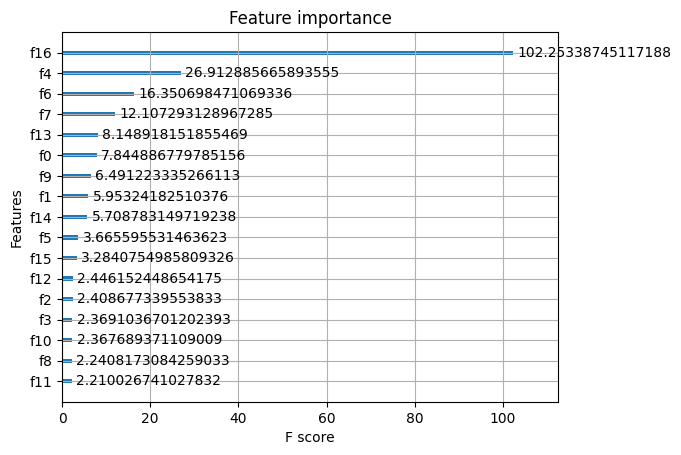

In [191]:
# calcular importancia de las características

print('Gain')
plot_importance(pipeline.named_steps['classifier'], importance_type='gain')
plt.show()

Weight


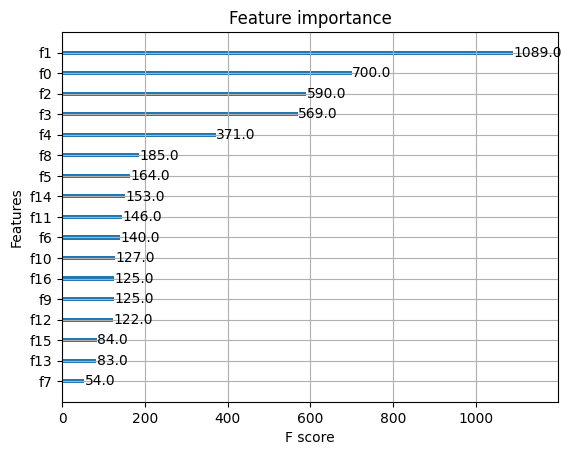

In [192]:
# weight

print('Weight')
plot_importance(pipeline.named_steps['classifier'], importance_type='weight')
plt.show()

Cover


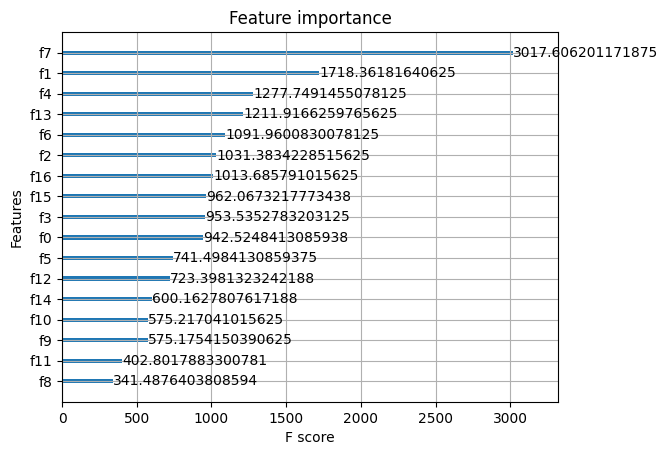

In [193]:
# cover

print('Cover')
plot_importance(pipeline.named_steps['classifier'], importance_type='cover')
plt.show()

¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

- Dependiendo del modelo, los resultados obtenidos son diferentes. Por ejemplo, para cover f7 es la feature más importante mientras que para weight es  la menos importante. Esta diferencia se debe a que cada método evalúa la importancia de las características desde una perspectiva diferente. Weight muestra cuántas veces se utiliza una característica para hacer divisiones, cover indica cuántos datos son influenciados por una característica durante el proceso de predicción y gain mide la mejora en la métrica de rendimiento al agregar una división basada en una característica.

- Las importancias obtenidas no son suficientes ya que cada gráfico muestra resultados diferentes.

- Respecto a la debilidad de estos métodos, es que no tienen en cuenta la correlación entre las variables, volviendolos propensos a ser redundantes.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [194]:
from sklearn.inspection import permutation_importance

# Método de permutación
result = permutation_importance(pipeline, X_test, y_test, n_repeats = 30,
                                random_state = 42)

# Se muestra el resultado
result

{'importances_mean': array([ 2.55675310e-02,  3.43642612e-04,  1.00072894e-02,  5.49307508e-03,
         2.79261689e-02, -4.24346558e-04,  2.69967718e-03, -1.06216807e-03,
         1.30167656e-05, -1.03613454e-03,  3.89461627e-03,  4.90836197e-02,
        -1.40841404e-03, -8.22659586e-04,  1.04134125e-03,  1.58804540e-04,
         1.53701968e-02]),
 'importances_std': array([0.00174667, 0.00101962, 0.00146554, 0.00086626, 0.00254107,
        0.00064677, 0.00108701, 0.00073309, 0.00066518, 0.00077942,
        0.00080073, 0.00327773, 0.00122005, 0.00128566, 0.00103971,
        0.00077355, 0.0015507 ]),
 'importances': array([[ 2.62417994e-02,  2.86629178e-02,  2.41330834e-02,
          2.48359888e-02,  2.48359888e-02,  2.35082787e-02,
          2.67104030e-02,  2.53045923e-02,  2.63980006e-02,
          2.33520775e-02,  2.60855983e-02,  2.57731959e-02,
          2.51483911e-02,  2.83505155e-02,  2.17119650e-02,
          2.46016870e-02,  2.54607935e-02,  2.50702905e-02,
          2.31177

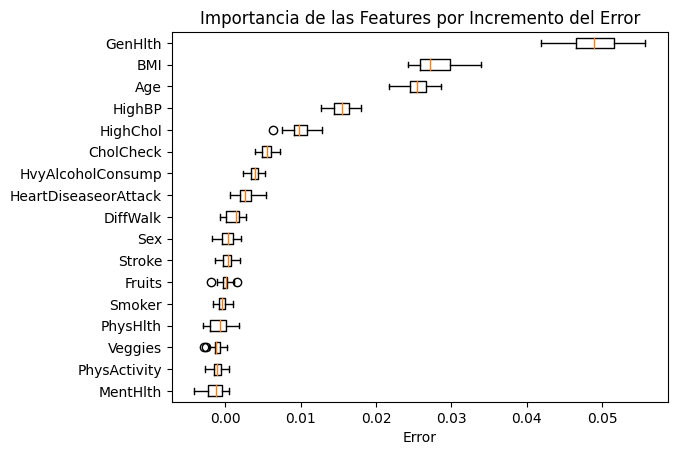

In [195]:
# Se grafica la importancia de las variables
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[perm_sorted_idx].T, vert=False,
    labels=np.array(df.columns)[perm_sorted_idx])
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

- ¿Cómo mide la importancia de las features su propuesta?

Es un método agnóstico al modelo, lo que hace es calcular una métrica de rendimiento(m1) con el conjunto de datos original, luego para cada característica individual, permutas aleatoriamente los valores de esa característica en todo el conjunto de datos y luego calcula su métrica de rendimiento (m2). El resultado será la diferencia de m2 y m1.

- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?

Las features con un mayor impacto son:

- - GenHlth: Tiene sentido ya que una persona más saludable es generalmente menos propensa a tener diabetes.
  - BMI: Tiene sentido ya que un BMI alto es indicio de sobrepeso u obesidad, lo cual se suele asociar a la diabetes.
  - Age: Tiene sentido, ya que al se mayor la edad, los resultados de una mala alimentación o salud se ven intensificados
  - HighBP: Tiene sentido ya que los diabéticos suelen desarrollar una alta presión arterial.
  - HighChol: Tiene sentido ya que un colesterol alto es generalmente producto de una mala alimentación lo que puede llevar a la diabetes.

- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?

Las conclusiones cambian bastante ya que hay muchas discrepancias entre las features más importantes según cada método. Variables como GenHlth no aparece dentro de las variables más importantes en ninguno de los métodos de importance plot y en permutation plot es la variable más importante, el resto de variables más importantes de permutation plot aparecen en el top 5 de al menos un método, pero solo BMI aparece en todos.



- Nombre y explique 3 ventajas y 3 desventajas del método implementado.
Ventajas:
- - Es un método agnóstico, por lo que se puede aplicar a cualquier algoritmo sin necesidad de conocer los detalles internos del modelo.
  - Puede ayudar a capturar interacciones no lineales o características de dependencia entre variables al evaluar la importancia de las características después de la permutación.
  - Es aplicable tanto a problemas de regresión como de clasificación.

Desventajas:
- - Posee un alto coste computacional, el cual crece con el tamaño del conjunto de datos.
  - La efectividad de la técnica puede depender del tamaño del conjunto de datos. En conjuntos de datos pequeños, la permutación de características puede ser más propensa a la variabilidad estocástica y proporcionar estimaciones menos estables de la importancia de las características.
  - Si las características están altamente correlacionadas, permutar una característica puede llevar a entradas poco realistas o incoherentes en los datos. Esto puede afectar la importancia percibida de las características y generar sesgos en la interpretación.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [196]:
#!pip install shap

In [197]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [198]:
# Inserte código para calcular shapley values aquí

import shap

explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer(X)

[23:55:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [199]:
shap_values

.values =
array([[-0.18430677,  1.1259726 , -0.10247472, ...,  0.00508144,
         0.01268959,  0.27702016],
       [ 0.42097944, -0.31537294, -0.22953002, ...,  0.00681756,
        -0.12388474,  0.24688418],
       [-0.28072277,  0.79586935, -0.06070028, ...,  0.02548741,
         0.01788305, -0.33944365],
       ...,
       [ 0.2209362 , -1.4183173 ,  0.23486865, ...,  0.10672548,
         0.00360608,  0.5007978 ],
       [ 0.05632466, -1.239025  , -0.37617365, ...,  0.0973704 ,
        -0.01203492,  0.41784364],
       [ 0.26205298, -1.9950212 ,  0.10057344, ..., -0.10315892,
        -0.00390981,  0.5255338 ]], dtype=float32)

.base_values =
array([0.07885536, 0.07885536, 0.07885536, ..., 0.07885536, 0.07885536,
       0.07885536], dtype=float32)

.data =
array([[ 4.,  1.,  0., ...,  0.,  0.,  1.],
       [12.,  1.,  1., ...,  0.,  1.,  1.],
       [13.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  1., ...,  1.,  0.,  1.],
       [11.,  0.,  1., ...,  1.,  0.,  1.]

¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

- values: Corresponden a los shap values. Estos muestran como contribuye una característica c/r al valor base. Esto se repite para cada una de las instancias del dataframe.
- base_values: Representan el valor base. Este corresponde al valor esperado de la salide de nuestro modelo, para el caso que no se tuviera información en las variables explicativas. En este caso, se tiene que el valor base corresponde al promedio de las predicciones de la variable diabetes.
- data: Corresponde a la matriz de entrada del modelo.

Si es posible atribuir un significado a la positividad/negatividad de cada valor, ya que el signo de un shap value indica el impacto que tiene la caracteristica c/r al valor base.

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

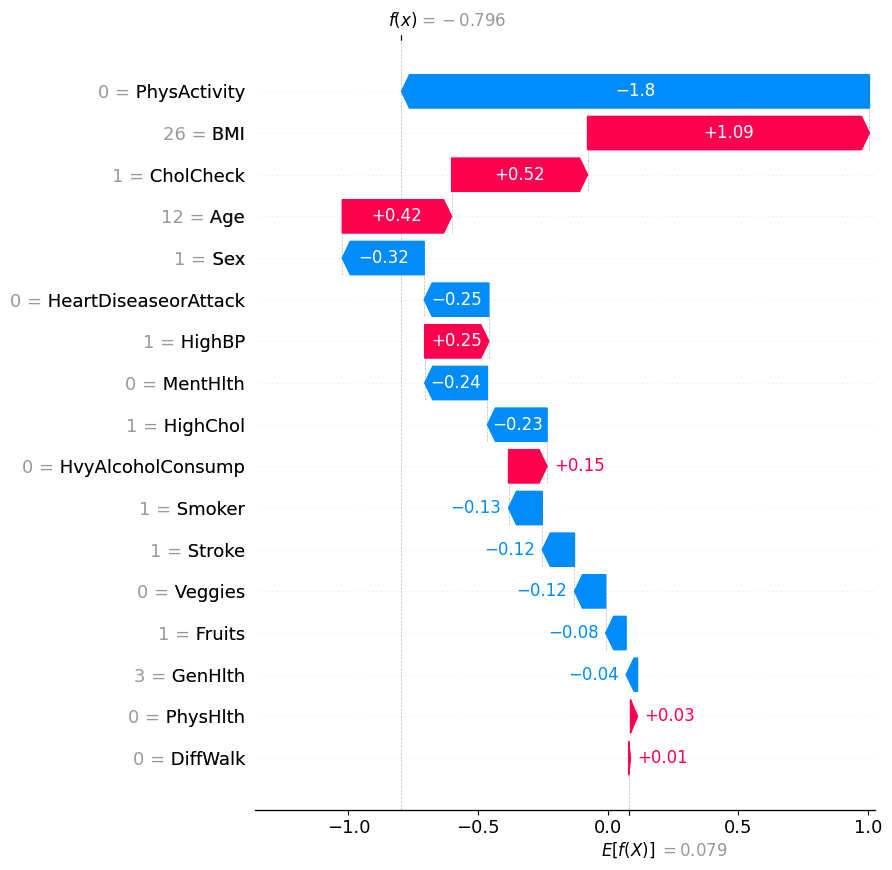

In [200]:
idx = 1
shap.plots.waterfall(shap_values[idx,:],
                     max_display=18)

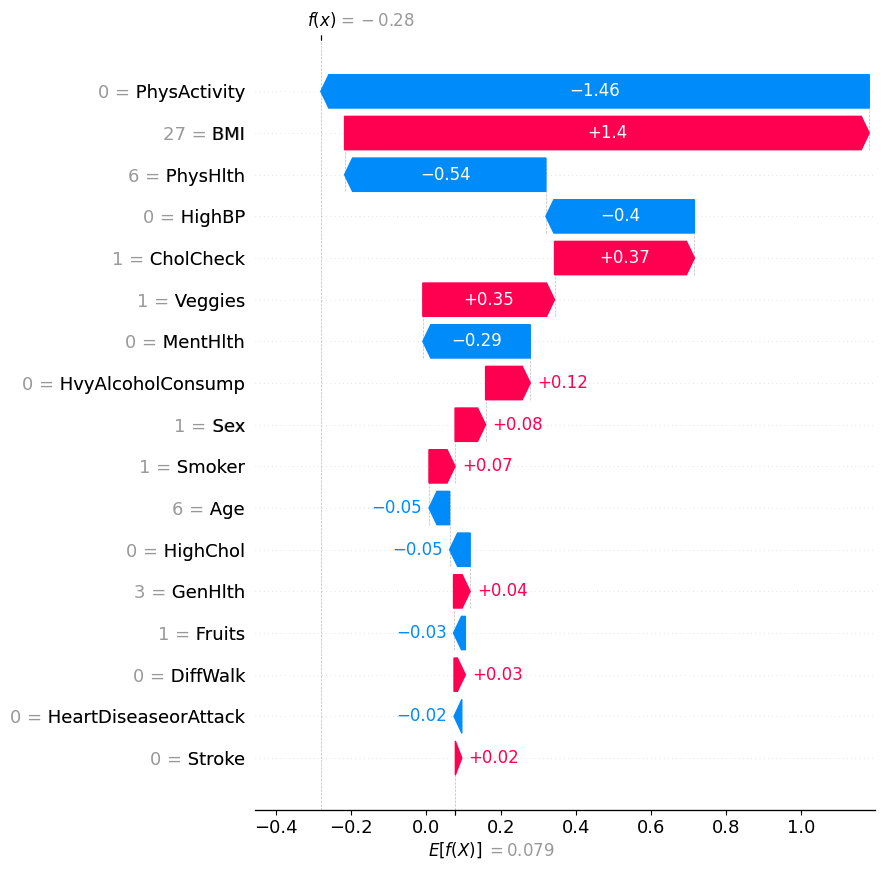

In [201]:
idx = 9
shap.plots.waterfall(shap_values[idx,:],
                     max_display=18)

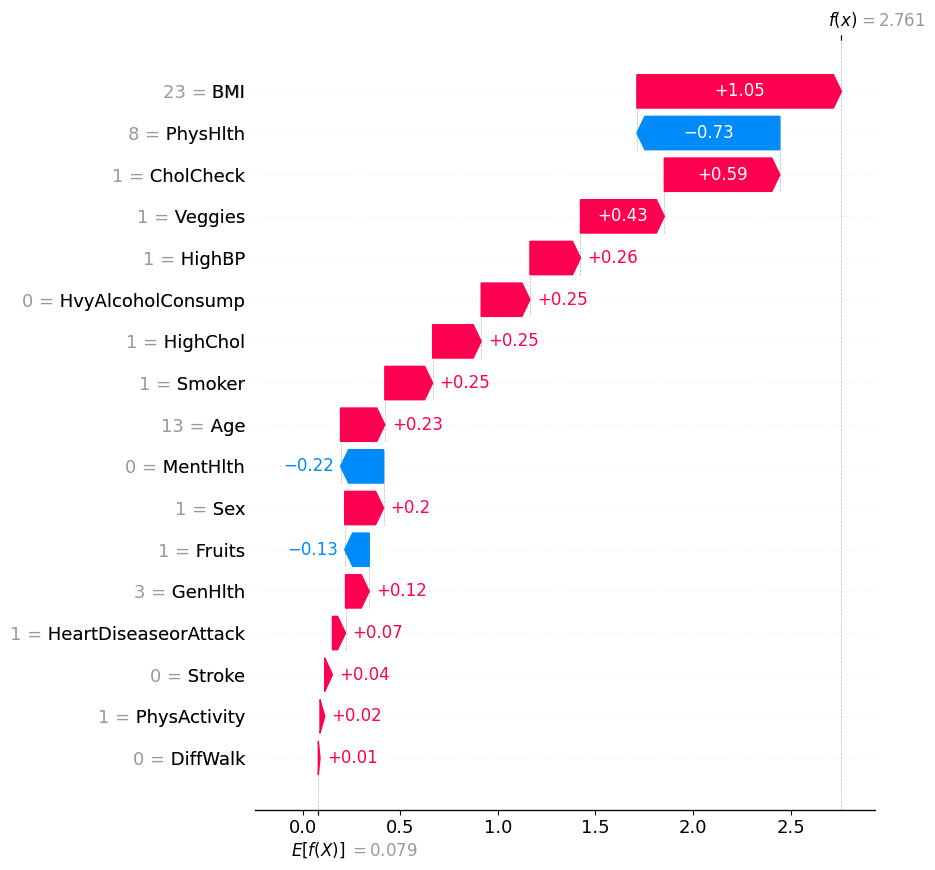

In [202]:
idx = 150
shap.plots.waterfall(shap_values[idx,:],
                     max_display=18)

- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
Esto depende de cada dato, pero en términos generales
- CholCheck, BMI, HvyAlcoholConsump, DiffWalk afectan de manera positiva en los 3 casos.
- Fruits y MentHlth afectan de manera negativa en los 3 casos.

El resto de variables afecta de manera distinta en cada caso.

- ¿Existe algún patrón común entre las instancias analizadas?

Las características que tienen un impacto tanto positivo como negativo que tienen en común.


- ¿Es posible generalizar estas conclusiones a todo el dataset?
No, ya que la muestra analizada es de 3 datos, por lo que no es representativa de todo el dataset.

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

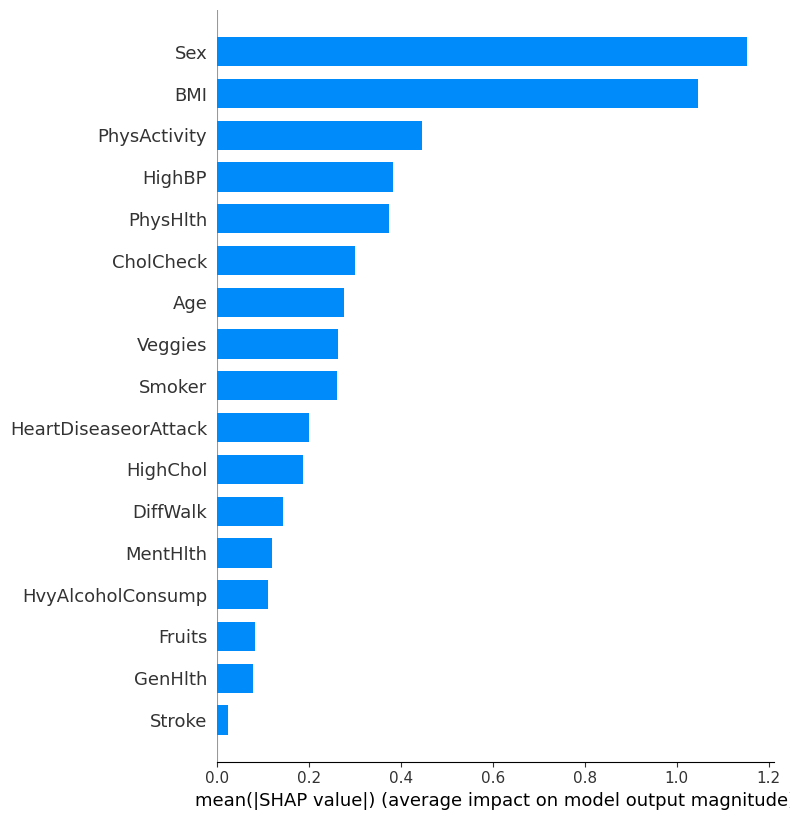

In [203]:
shap.summary_plot(shap_values, X, plot_type = "bar")

¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

- Las conclusiones generadas a nivel global indican la importancia de una variable para hacer una clasificación, independiente del signo de su contribución. Además una característica puede ser la más relevante a nivel global pero no necesariamente lo es para alguna instancia en específico, por ejemplo la variable Sex no es la más relevante en ninguno de los casos vistos antse.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

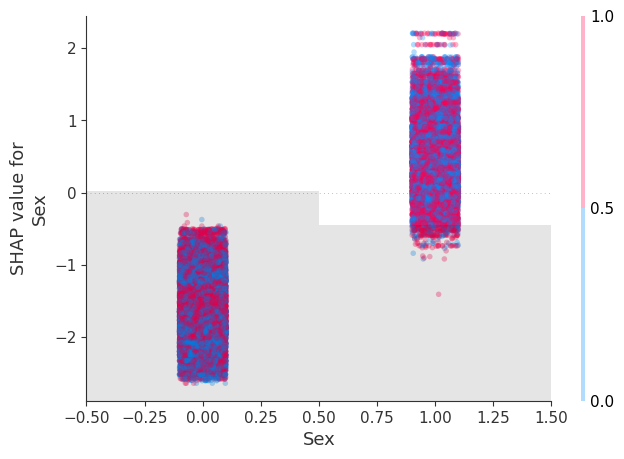

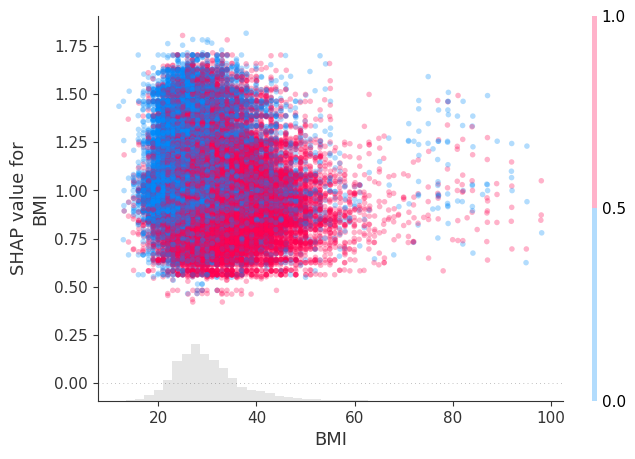

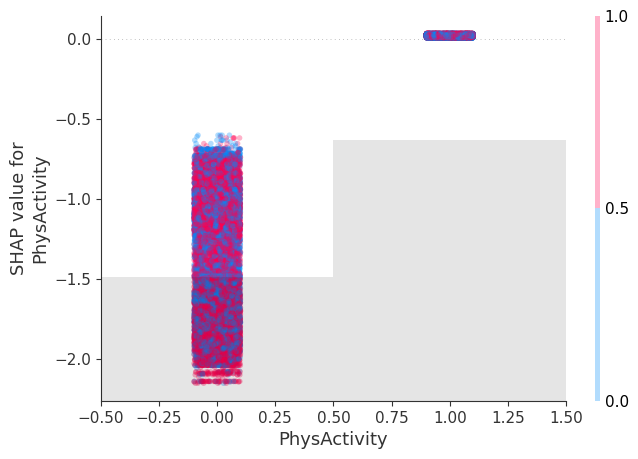

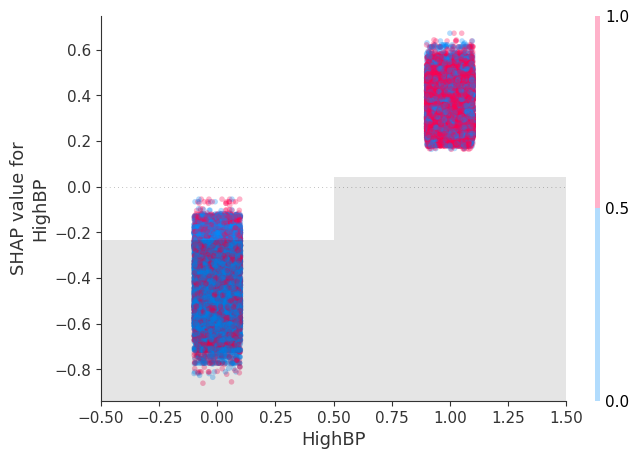

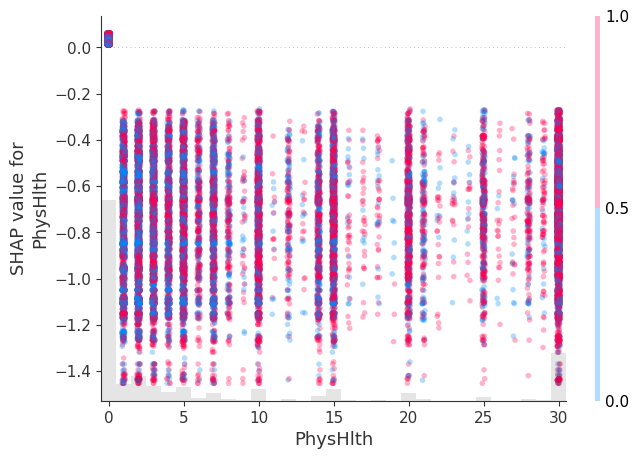

In [204]:
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

# scatter plot
for name in feature_importance_names[:5]:
    shap.plots.scatter(shap_values[:, name], color=df.Diabetes.values, alpha=0.3)
    print('')

¿Qué puede concluir de sus resultados?

- En el caso de BMI es posible dislumbrar dos clusters que separan a los pacientes con mayor probabilidad de tener diabetes de los que no.
- En la variable HighBP esta diferencia es más notoria en los shap values, los pacientes con alta presión sanguínea presentan una mayor probabilidad de tener diabetes.
- Para el resto de variables no hay una relación clara.

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

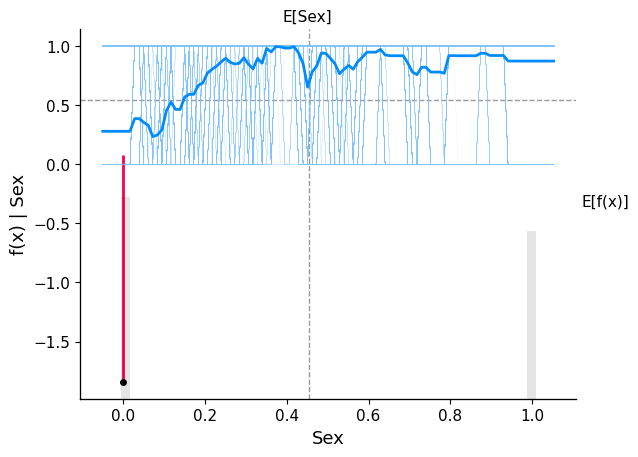

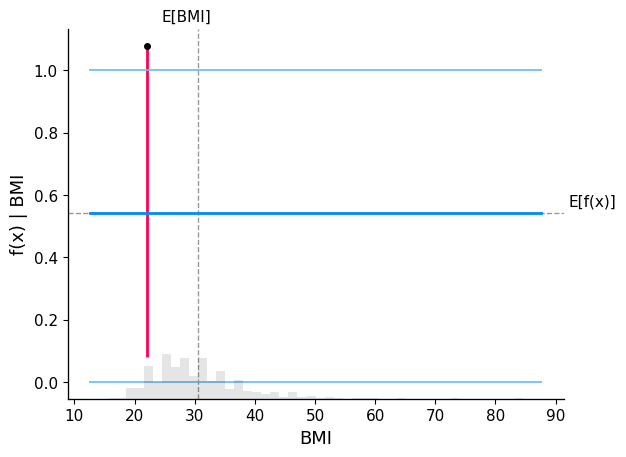

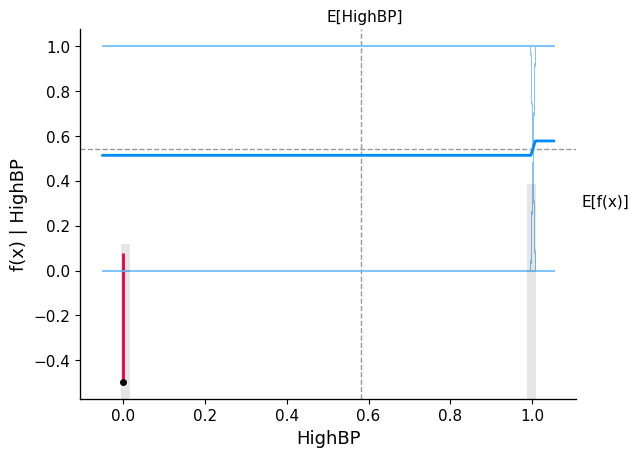

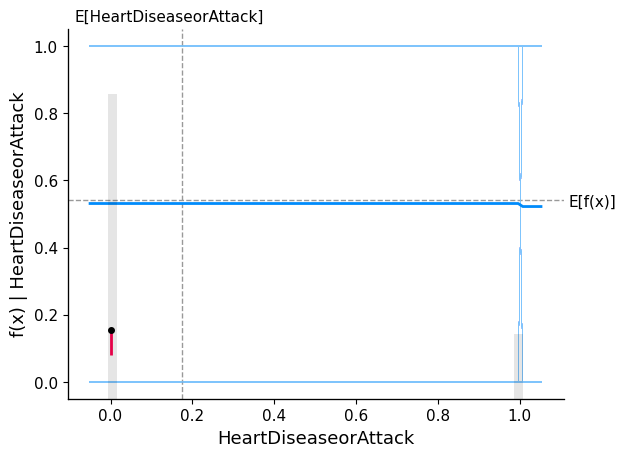

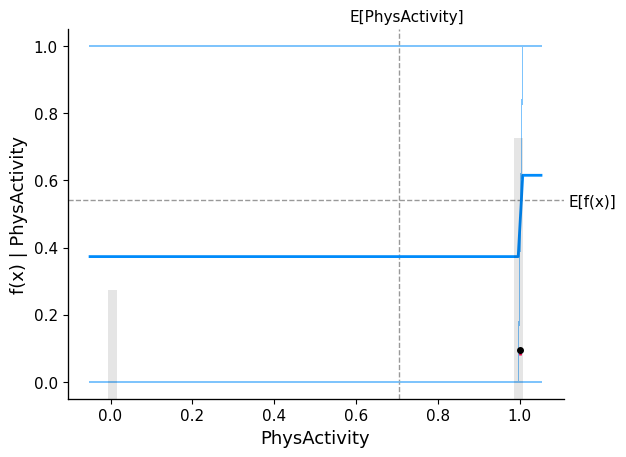

In [205]:
X1000 = shap.utils.sample(X, 1000)
features = ['Sex', 'BMI', 'HighBP', 'HeartDiseaseorAttack', 'PhysActivity']
sample_ind = 20

for i in range(5):
  shap.partial_dependence_plot(features[i], pipeline.named_steps['classifier'].predict,
                            X1000, model_expected_value = True,
                            feature_expected_value = True, ice = True,
                            shap_values=shap_values[sample_ind:sample_ind+1,:]
                            )

¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

- Con respecto a los PDP se comenta que al pertenecer a la clase 1 en las variables Sex, HighBP y PhysActivity aumenta la esperanza de la función f(x), lo que indica que aumenta la probabilidad de padecer diabetes.La variable BMI no presenta cambios en su esperanza al aumentar el valor de BMI, lo cual no coincide con lo esperado teóricamente. La variable PhysActivity presenta una disminución de esperanza de la función f(x) lo cual tiene sentido.

- No es posible hablar de causalidad fuera de la muestra. Si bien este método entrega conclusiones para la muestra de 100 pacientes, no es posible garantizar que estos resultados se peudan generalizar para la muestra completa.


## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [206]:
#!pip install alibi

In [207]:
from alibi.explainers import AnchorTabular

# Sistema de reglas
predict_fn = lambda x: pipeline.named_steps['classifier'].predict(x)
explainer = AnchorTabular(predict_fn,
                          pipeline.named_steps['preprocessor'].feature_names_in_,
                          seed = 1)
explainer.fit(X_train.to_numpy())

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 1, 'disc_perc': (25, 50, 75)},
  'version': '0.9.4'}
)

In [209]:
class_names = ["sin diabetes", "con diabetes"]

idx = 1000
# explicar predicción idx 1000
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print('-------------------------------------------------------------------------')

idx = 3001
# explicar predicción idx 3001
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print('-------------------------------------------------------------------------')

idx = 5751
# explicar predicción idx 5751
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  sin diabetes
Anchor: Sex <= 0.00 AND PhysActivity <= 0.00 AND HighChol > 0.00 AND HeartDiseaseorAttack <= 0.00
Precision: 1.00
Coverage: 0.09
-------------------------------------------------------------------------
Prediction:  sin diabetes
Anchor: PhysActivity <= 0.00 AND Smoker <= 0.00 AND DiffWalk > 0.00 AND MentHlth <= 0.00 AND Fruits > 0.00 AND GenHlth > 2.00 AND HighBP > 0.00 AND Sex > 0.00
Precision: 1.00
Coverage: 0.00
-------------------------------------------------------------------------
Prediction:  con diabetes
Anchor: Sex > 0.00 AND HighBP <= 0.00 AND HighChol > 0.00
Precision: 0.96
Coverage: 0.07


Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

- Podemos ver en la cobertura que afectan estas reglas que la proporción de población afectada es bastante baja (ver parámetro coverage). A pesar de esto las precisiones alcanzadas son bastante altas.

- Tienen sentido las reglas propuestas, ya que son variables binarias o discretas (lo que hace más clara su separación) por lo que dependiendo del valor entero que tomen, será un indicador de de factor de riesgo o no.

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Dependiendo de la situación, el método que entrega las mejores conclusiones va a variar. Si el dr Simi tiene tiempo y por ende, el tiempo de procesamiento no es un problema. los shap values son una buena opción puesto que ofrecen una interpretación para cada dato, que en este caso se traduce en cada paciente, ayudandolo a entender como cada variable contribuye a la hora de clasificar cada paciente en particular. Ahora si no tiene tiempo, es recomendable utilizar permutation feature importance ya que este método no asume que las variables sean independientes o que estés descorrelacionadas, aunque se recomienda hacer un filtrado previo de variables con alta correlación.

> Dado que cada paciente posee un organismo distinto, se le recomienda utilizar métodos agnósticos locales. Pero si está buscando una comprensión más general del fenómeno, los métodos agnósticos globales son más adecuados.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>